# PubMed QA Evaluation

This notebook evaluates various large language models (LLMs) on their ability to answer yes/no/maybe medical questions from PubMed abstracts. The models are evaluated on their accuracy in understanding medical research literature and providing appropriate answers.

## Setup and Imports

First, we'll import the necessary libraries and set up the environment.

In [49]:
import pandas as pd
import numpy as np
import os
import time
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from dotenv import load_dotenv

# Try to import the OpenAI and Groq libraries
try:
    from openai import AzureOpenAI
    from groq import Groq
except ImportError:
    print("Warning: Some required libraries are missing. Install with: pip install openai groq")

# Set up display options
pd.set_option('display.max_colwidth', None)

## Load Environment Variables

Next, we'll load API keys and configurations from environment variables.

In [50]:
def load_environment():
    """Load environment variables from .env file"""
    load_dotenv()
    
    # Azure OpenAI configuration
    azure_api_key = os.getenv("AZURE_OPENAI_KEY")
    azure_api_version = os.getenv("AZURE_OPENAI_VERSION")
    azure_endpoint = os.getenv("AZURE_ENDPOINT")
    azure_deployment_name = os.getenv("AZURE_DEPLOYMENT_NAME", "gpt-4o-mini")
    
    # Groq API configuration
    groq_api_key = os.getenv("GROQ_API_KEY_MAIN")
    
    return {
        'azure_api_key': azure_api_key,
        'azure_api_version': azure_api_version,
        'azure_endpoint': azure_endpoint,
        'azure_deployment_name': azure_deployment_name,
        'groq_api_key': groq_api_key
    }

# Load environment variables
env_vars = load_environment()

# Set constants based on environment variables
AZURE_DEPLOYMENT_NAME = env_vars['azure_deployment_name']

print(f"Azure Deployment: {AZURE_DEPLOYMENT_NAME}")

Azure Deployment: gpt-4o-mini


## Initialize API Clients

Set up the clients for Azure OpenAI and Groq.

In [51]:
def init_clients(env_vars):
    """Initialize API clients"""
    clients = {}
    
    # Initialize Azure OpenAI client if credentials are available
    if all([env_vars['azure_api_key'], env_vars['azure_api_version'], env_vars['azure_endpoint']]):
        try:
            clients['azure'] = AzureOpenAI(
                api_key=env_vars['azure_api_key'],
                api_version=env_vars['azure_api_version'],
                base_url=f"{env_vars['azure_endpoint']}/openai/deployments/{env_vars['azure_deployment_name']}"
            )
            print("Azure OpenAI client initialized successfully")
        except Exception as e:
            print(f"Error initializing Azure client: {e}")
    
    # Initialize Groq client if credentials are available
    if env_vars['groq_api_key']:
        try:
            clients['groq'] = Groq(api_key=env_vars['groq_api_key'])
            print("Groq client initialized successfully")
        except Exception as e:
            print(f"Error initializing Groq client: {e}")
            
    return clients

# Initialize the API clients
clients = init_clients(env_vars)

Azure OpenAI client initialized successfully
Groq client initialized successfully


## Define Models for Evaluation

Set up the models we want to evaluate.

In [52]:
# Define Groq models to evaluate
GROQ_MODELS = [
    "llama-3.3-70b-versatile",
    "mistral-saba-24b",
    "llama-3.1-8b-instant",
    "gemma2-9b-it"
]

# Build the full model list
MODELS = []

if 'azure' in clients:
    MODELS.append({"provider": "azure", "name": env_vars['azure_deployment_name']})

if 'groq' in clients:
    for model in GROQ_MODELS:
        MODELS.append({"provider": "groq", "name": model})

print(f"Models to evaluate: {len(MODELS)}")
for model in MODELS:
    print(f"- {model['provider']}: {model['name']}")

Models to evaluate: 5
- azure: gpt-4o-mini
- groq: llama-3.3-70b-versatile
- groq: mistral-saba-24b
- groq: llama-3.1-8b-instant
- groq: gemma2-9b-it


## Load and Explore Data

Load the PubMed dataset and examine its structure.

In [53]:
# Define paths
data_path = "../data/processed/pubmedqa_processed.csv"
results_dir = "../results/QA/PubMed_TorF"
plots_dir = os.path.join(results_dir, "plots")

# Create directories if they don't exist
os.makedirs(results_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

# Load the dataset
df = pd.read_csv(data_path)

# Display basic information
print(f"Dataset loaded with {len(df)} questions")
df.info()

Dataset loaded with 500 questions
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   context         500 non-null    object
 1   question        500 non-null    object
 2   options         500 non-null    object
 3   correct_option  500 non-null    object
 4   correct_answer  500 non-null    object
 5   long_answer     500 non-null    object
dtypes: object(6)
memory usage: 23.6+ KB


In [54]:
# Examine the distribution of answers
answer_counts = df['correct_answer'].value_counts()
print("Answer distribution:")
print(answer_counts)


Answer distribution:
correct_answer
yes      283
no       155
maybe     62
Name: count, dtype: int64


In [65]:
# Create a balanced sample with 15 yes, 15 no, and 20 maybe questions
yes_samples = df[df['correct_answer'] == 'yes'].sample(n=30, random_state=42)
no_samples = df[df['correct_answer'] == 'no'].sample(n=30, random_state=42)
maybe_samples = df[df['correct_answer'] == 'maybe'].sample(n=40, random_state=42)

# Combine the samples
balanced_df = pd.concat([yes_samples, no_samples, maybe_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

# Display the balanced dataset
print(f"Balanced dataset created with {len(balanced_df)} questions")
print(balanced_df['correct_answer'].value_counts())


Balanced dataset created with 100 questions
correct_answer
maybe    40
no       30
yes      30
Name: count, dtype: int64


In [66]:
balanced_df.sample(3)

,context,question,options,correct_option,correct_answer,long_answer
1,"['Clinically positive axillary nodes are widely considered a contraindication to sentinel lymph node (SLN) biopsy in breast cancer, yet no data support this mandate. In fact, data from the era of axillary lymph node dissection (ALND) suggest that clinical examination of the axilla is falsely positive in as many as 30% of cases. Here we report the results of SLN biopsy in a selected group of breast cancer patients with palpable axillary nodes classified as either moderately or highly suspicious for metastasis.'\n 'Among 2,027 consecutive SLN biopsy procedures performed by two experienced surgeons, clinically suspicious axillary nodes were identified in 106, and categorized as group 1 (asymmetric enlargement of the ipsilateral axillary nodes moderately suspicious for metastasis, n = 62) and group 2 (clinically positive axillary nodes highly suspicious for metastasis, n = 44).'\n 'Clinical examination of the axilla was inaccurate in 41% of patients (43 of 106) overall, and was falsely positive in 53% of patients (33 of 62) with moderately suspicious nodes and 23% of patients (10 of 44) with highly suspicious nodes. False-positive results were less frequent with larger tumor size (p = 0.002) and higher histologic grade (p = 0.002), but were not associated with age, body mass index, or a previous surgical biopsy.']",Is the clinically positive axilla in breast cancer really a contraindication to sentinel lymph node biopsy?,"{'A': 'yes', 'B': 'no', 'C': 'maybe'}",B,no,"Clinical axillary examination in breast cancer is subject to false-positive results, and is by itself insufficient justification for axillary lymph node dissection. If other means of preoperative assessment such as palpation- or image-guided fine needle aspiration are negative or indeterminate, then SLN biopsy deserves wider consideration as an alternative to routine axillary lymph node dissection in the clinically node-positive setting."
13,"['Kell haemolytic disease in pregnancies has been suggested to be associated with decreased fetal platelet counts. The aim of this study was to evaluate the incidence and clinical significance of fetal thrombocytopenia in pregnancies complicated by Kell alloimmunization.'\n 'In this retrospective cohort study, fetal platelet counts were performed in 42 pregnancies with severe Kell alloimmunization prior to the first intrauterine blood transfusion. Platelet counts from 318 first intrauterine transfusions in RhD alloimmunized pregnancies were used as controls.'\n 'Fetal thrombocytopenia (platelet count<150 x 10(9)/l) was found in 4/42 (10%) in the Kell group and in 84/318 (26%) in the RhD group. None of the fetuses in the Kell alloimmunized pregnancies, including 15 with severe hydrops, had a clinically significant thrombocytopenia defined as a platelet count<50 x 10(9)/l. In the RhD alloimmunized pregnancies, 2/230 (1%) of the non-hydropic fetuses and 7/30 (23%) of the severely hydropic fetuses had a clinically significant thrombocytopenia.']",Kell alloimmunization in pregnancy: associated with fetal thrombocytopenia?,"{'A': 'yes', 'B': 'no', 'C': 'maybe'}",B,no,"In contrast to fetuses with severe anaemia and hydrops due to RhD alloimmunization, fetuses with severe anaemia due to Kell alloimmunization are generally not at risk for substantial thrombocytopenia."
77,"['One of the problems with manual resuscitators is the difficulty in achieving accurate volume delivery. The volume delivered to the patient varies by the physical characteristics of the person and method. This study was designed to compare tidal volumes delivered by the squeezing method, physical characteristics and education and practice levels.'\n '114 individuals trained in basic life support and bag-valve-mask ventilation participated in this study. Individual characteristics were obtained by the observer and the education and practice level were described by the subjects. Ventilation was deliver

## Create Evaluation Functions

Define the functions needed for prompt creation, response processing, and model evaluation.

In [67]:
def create_prompt(context, question, options):
    """Create a prompt for the LLM models"""
    prompt = f"""Based on the following medical research context, please answer the question with ONLY 'yes', 'no', or 'maybe'. Do not provide explanations.

Context: {context}

Question: {question}

Options:
A: yes
B: no
C: maybe

Your answer (respond with only 'yes', 'no', or 'maybe'):"""
    return prompt

def process_response(response_text):
    """Extract a yes/no/maybe answer from the model response"""
    # Convert to lowercase and remove punctuation
    cleaned_text = response_text.lower().strip()
    
    # Extract yes/no/maybe from response
    if 'yes' in cleaned_text and ('no' not in cleaned_text or cleaned_text.find('yes') < cleaned_text.find('no')):
        return 'yes'
    elif 'no' in cleaned_text:
        return 'no'
    elif 'maybe' in cleaned_text:
        return 'maybe'
    else:
        # Try to find option A/B/C if direct answer not found
        if re.search(r'\b[aA]\b', cleaned_text):
            return 'yes'
        elif re.search(r'\b[bB]\b', cleaned_text):
            return 'no'
        elif re.search(r'\b[cC]\b', cleaned_text):
            return 'maybe'
        else:
            # Default to most common answer if nothing found
            return 'yes'

def get_azure_response(client, prompt, deployment_name):
    """Get a response from Azure OpenAI"""
    try:
        response = client.chat.completions.create(
            model=deployment_name,
            messages=[
                {"role": "system", "content": "You are a medical research assistant that answers questions based on medical research papers."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.0,
            max_tokens=50
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Azure API error: {e}")
        time.sleep(5)  # Wait before retrying
        return "Error"

def get_groq_response(client, model_name, prompt):
    """Get a response from Groq"""
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "You are a medical research assistant that answers questions based on medical research papers."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.0,
            max_tokens=50
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Groq API error with {model_name}: {e}")
        time.sleep(5)  # Wait before retrying
        return "Error"

In [68]:
def evaluate_model(model_info, data_df, clients, env_vars, results_dir, max_samples=None):
    """Evaluate a model on the dataset"""
    provider = model_info['provider']
    model_name = model_info['name']
    
    print(f"\nEvaluating {provider} - {model_name}...")
    
    # Limit samples if specified
    if max_samples and max_samples < len(data_df):
        eval_df = data_df.sample(max_samples, random_state=42).reset_index(drop=True)
        print(f"Using {max_samples} samples for evaluation")
    else:
        eval_df = data_df
    
    results = []
    start_time = time.time()
    
    for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df)):
        prompt = create_prompt(row['context'], row['question'], row['options'])
        
        # Get response based on provider
        if provider == 'azure':
            response_text = get_azure_response(clients['azure'], prompt, env_vars['azure_deployment_name'])
        else:  # groq
            response_text = get_groq_response(clients['groq'], model_name, prompt)
            
        if response_text == "Error":
            # Retry once more if there was an error
            time.sleep(2)
            if provider == 'azure':
                response_text = get_azure_response(clients['azure'], prompt, env_vars['azure_deployment_name'])
            else:  # groq
                response_text = get_groq_response(clients['groq'], model_name, prompt)
        
        processed_response = process_response(response_text)
        
        results.append({
            'idx': idx,
            'question': row['question'],
            'context': row['context'],
            'options': row['options'],
            'correct_answer': row['correct_answer'],
            'model_response': response_text,
            'processed_response': processed_response,
            'is_correct': processed_response == row['correct_answer']
        })
        
        # Short pause between requests to avoid rate limiting
        time.sleep(0.5)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Calculate basic metrics
    correct_count = sum(1 for r in results if r['is_correct'])
    accuracy = correct_count / len(results)
    
    print(f"Evaluation completed in {elapsed_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f} ({correct_count}/{len(results)})")
    
    # Save results to file
    model_id = f"{provider}_{model_name.replace('-', '_')}"
    result_file = os.path.join(results_dir, f"{model_id}_results.json")
    
    with open(result_file, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"Results saved to {result_file}")
    
    return results

In [69]:
def calculate_metrics(model_results):
    """Calculate evaluation metrics from model results"""
    y_true = [item['correct_answer'] for item in model_results]
    y_pred = [item['processed_response'] for item in model_results]
    
    # Calculate accuracy
    acc = accuracy_score(y_true, y_pred)
    
    # Generate confusion matrix
    labels = ['yes', 'no', 'maybe']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Classification report
    report = classification_report(y_true, y_pred, labels=labels, output_dict=True)
    
    return {
        'accuracy': acc,
        'confusion_matrix': cm,
        'report': report,
        'labels': labels
    }

In [70]:
def plot_confusion_matrix(cm, labels, title, output_path=None):
    """Generate and save a confusion matrix visualization"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path)
        print(f"Confusion matrix saved to {output_path}")
    
    plt.show()

def plot_accuracy_comparison(metrics_dict, plots_dir=None):
    """Generate and save an accuracy comparison chart"""
    models = list(metrics_dict.keys())
    accuracies = [metrics_dict[model]['accuracy'] for model in models]
    
    # Clean model names for display
    display_names = [model.replace('_', ' ').replace('azure ', '').replace('groq ', '') for model in models]
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(display_names, accuracies, color=sns.color_palette('muted', len(models)))
    
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.ylim(0.0, 1.0)
    plt.xticks(rotation=45, ha='right')
    
    # Add accuracy values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', rotation=0)
    
    plt.tight_layout()
    
    if plots_dir:
        output_path = os.path.join(plots_dir, 'accuracy_comparison.png')
        plt.savefig(output_path)
        print(f"Accuracy comparison saved to {output_path}")
    
    plt.show()

## Test Single Example

Let's test a single example to make sure our prompting and response processing is working correctly.

In [71]:
# Select a random example from the balanced set
test_row = balanced_df.sample(1).iloc[0]

print(f"Question: {test_row['question']}")
print(f"\nContext excerpt: {str(test_row['context'])[:300]}...")
print(f"\nCorrect answer: {test_row['correct_answer']}")

# Create a prompt
test_prompt = create_prompt(test_row['context'], test_row['question'], test_row['options'])

print("\n--- Prompt ---")
print(test_prompt)

Question: Body diffusion-weighted MR imaging of uterine endometrial cancer: is it helpful in the detection of cancer in nonenhanced MR imaging?

Context excerpt: ['In this study, the authors discussed the feasibility and value of diffusion-weighted (DW) MR imaging in the detection of uterine endometrial cancer in addition to conventional nonenhanced MR images.'
 'DW images of endometrial cancer in 23 patients were examined by using a 1.5-T MR scanner. This s...

Correct answer: yes

--- Prompt ---
Based on the following medical research context, please answer the question with ONLY 'yes', 'no', or 'maybe'. Do not provide explanations.

Context: ['In this study, the authors discussed the feasibility and value of diffusion-weighted (DW) MR imaging in the detection of uterine endometrial cancer in addition to conventional nonenhanced MR images.'
 'DW images of endometrial cancer in 23 patients were examined by using a 1.5-T MR scanner. This study investigated whether or not DW images offe

In [72]:
# Test with one model if available
if 'azure' in clients:
    print("Testing with Azure OpenAI...")
    test_response = get_azure_response(clients['azure'], test_prompt, env_vars['azure_deployment_name'])
    print(f"\nRaw response: {test_response}")
    processed = process_response(test_response)
    print(f"Processed response: {processed}")
    print(f"Correct: {processed == test_row['correct_answer']}")
elif 'groq' in clients:
    print("Testing with Groq...")
    test_response = get_groq_response(clients['groq'], GROQ_MODELS[0], test_prompt)
    print(f"\nRaw response: {test_response}")
    processed = process_response(test_response)
    print(f"Processed response: {processed}")
    print(f"Correct: {processed == test_row['correct_answer']}")
else:
    print("No API clients available for testing")

Testing with Azure OpenAI...

Raw response: yes
Processed response: yes
Correct: True


## Run Evaluation

Now we'll run the evaluation on our balanced dataset with all our models.

In [73]:
# Use the balanced dataset for evaluation
eval_df = balanced_df
print(f"Using balanced dataset with {len(eval_df)} questions for evaluation")

# Initialize storage for results
all_model_results = {}

Using balanced dataset with 100 questions for evaluation


In [74]:
# Run evaluation for each model
for model in MODELS:
    model_id = f"{model['provider']}_{model['name'].replace('-', '_')}"
    
    # Check if results already exist
    result_file = os.path.join(results_dir, f"{model_id}_results_balanced.json")
    if os.path.exists(result_file):
        print(f"Loading existing results for {model_id}")
        with open(result_file, 'r') as f:
            results = json.load(f)
    else:
        # Run evaluation for this model
        results = evaluate_model(model, eval_df, clients, env_vars, results_dir)
        # Save with special filename to differentiate from other evaluations
        with open(result_file, 'w') as f:
            json.dump(results, f, indent=2)
        print(f"Results saved to {result_file}")
    
    all_model_results[model_id] = results


Evaluating azure - gpt-4o-mini...


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluation completed in 127.27 seconds
Accuracy: 0.6400 (64/100)
Results saved to ../results/QA/PubMed_TorF\azure_gpt_4o_mini_results.json
Results saved to ../results/QA/PubMed_TorF\azure_gpt_4o_mini_results_balanced.json

Evaluating groq - llama-3.3-70b-versatile...


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluation completed in 194.39 seconds
Accuracy: 0.5700 (57/100)
Results saved to ../results/QA/PubMed_TorF\groq_llama_3.3_70b_versatile_results.json
Results saved to ../results/QA/PubMed_TorF\groq_llama_3.3_70b_versatile_results_balanced.json

Evaluating groq - mistral-saba-24b...


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluation completed in 346.47 seconds
Accuracy: 0.6500 (65/100)
Results saved to ../results/QA/PubMed_TorF\groq_mistral_saba_24b_results.json
Results saved to ../results/QA/PubMed_TorF\groq_mistral_saba_24b_results_balanced.json

Evaluating groq - llama-3.1-8b-instant...


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluation completed in 369.36 seconds
Accuracy: 0.5400 (54/100)
Results saved to ../results/QA/PubMed_TorF\groq_llama_3.1_8b_instant_results.json
Results saved to ../results/QA/PubMed_TorF\groq_llama_3.1_8b_instant_results_balanced.json

Evaluating groq - gemma2-9b-it...


  0%|          | 0/100 [00:00<?, ?it/s]

Evaluation completed in 243.27 seconds
Accuracy: 0.6200 (62/100)
Results saved to ../results/QA/PubMed_TorF\groq_gemma2_9b_it_results.json
Results saved to ../results/QA/PubMed_TorF\groq_gemma2_9b_it_results_balanced.json


## Analyze Results

Let's analyze the performance of each model on our balanced dataset.

In [75]:
# Calculate metrics for each model
model_metrics = {}
for model_id, results in all_model_results.items():
    model_metrics[model_id] = calculate_metrics(results)
    
# Print accuracy summary
print("Model Accuracy Summary:")
for model_id, metrics in model_metrics.items():
    print(f"- {model_id}: {metrics['accuracy']:.4f}")

Model Accuracy Summary:
- azure_gpt_4o_mini: 0.6400
- groq_llama_3.3_70b_versatile: 0.5700
- groq_mistral_saba_24b: 0.6500
- groq_llama_3.1_8b_instant: 0.5400
- groq_gemma2_9b_it: 0.6200


Confusion matrix saved to ../results/QA/PubMed_TorF\plots\azure_gpt_4o_mini_confusion_matrix_balanced.png


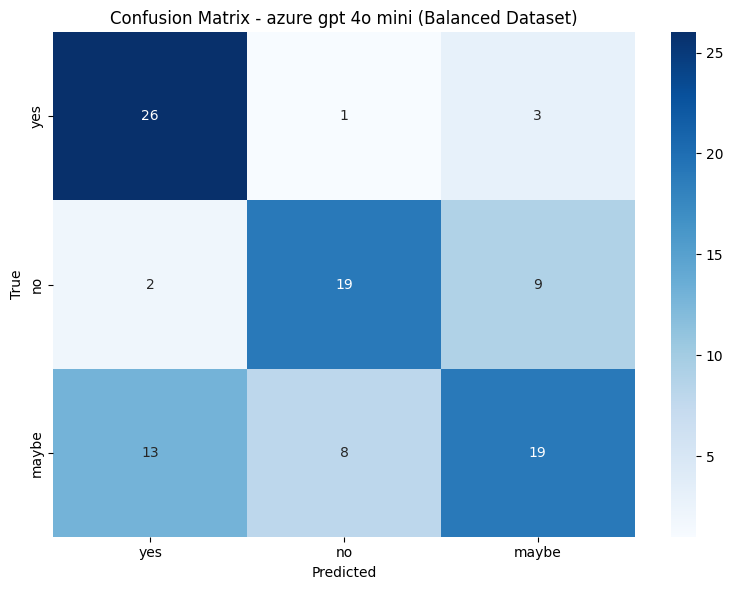

Confusion matrix saved to ../results/QA/PubMed_TorF\plots\groq_llama_3.3_70b_versatile_confusion_matrix_balanced.png


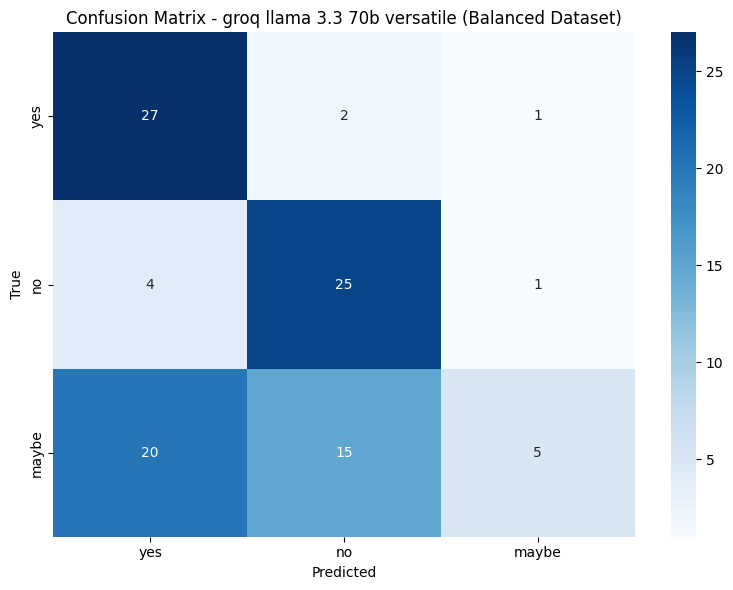

Confusion matrix saved to ../results/QA/PubMed_TorF\plots\groq_mistral_saba_24b_confusion_matrix_balanced.png


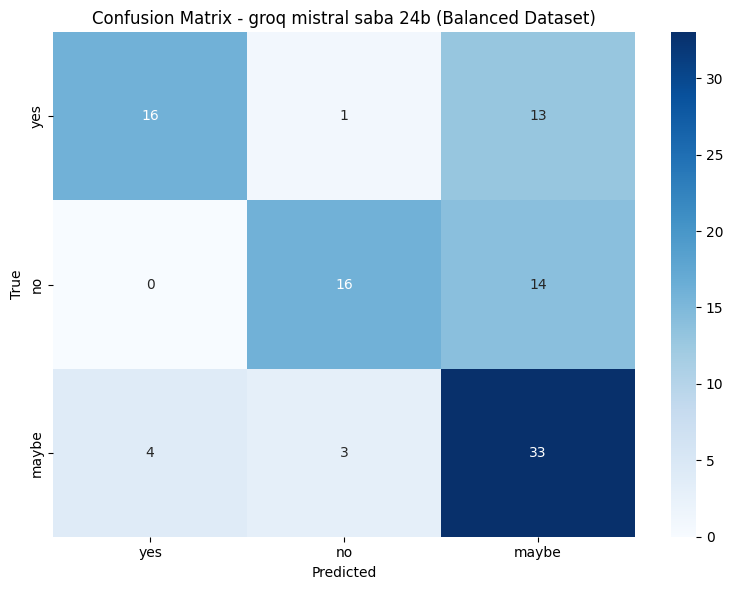

Confusion matrix saved to ../results/QA/PubMed_TorF\plots\groq_llama_3.1_8b_instant_confusion_matrix_balanced.png


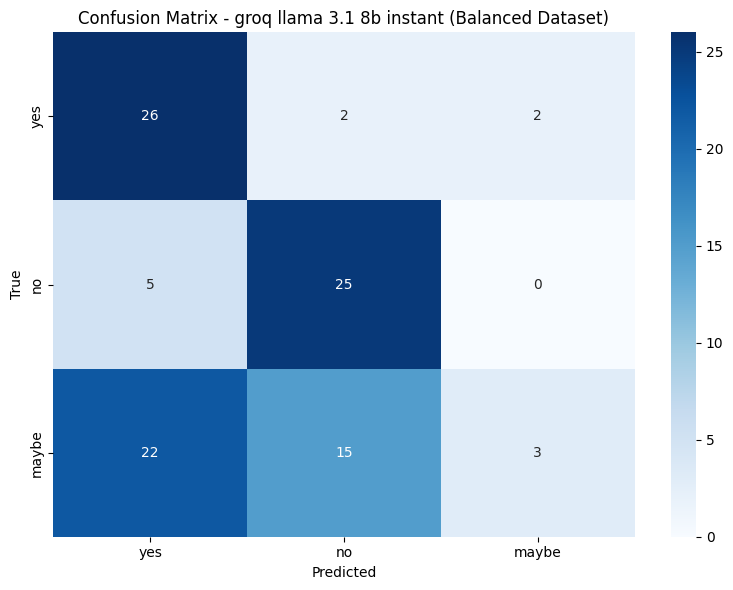

Confusion matrix saved to ../results/QA/PubMed_TorF\plots\groq_gemma2_9b_it_confusion_matrix_balanced.png


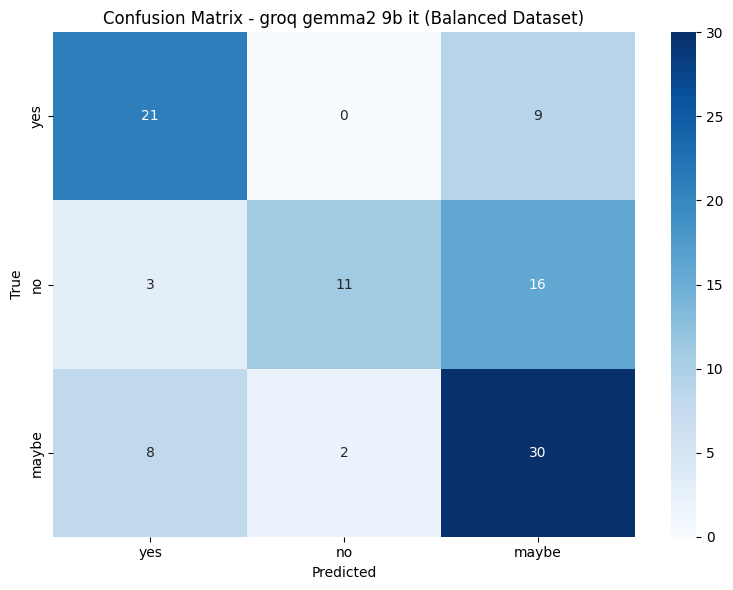

In [76]:
# Generate confusion matrices
for model_id, metrics in model_metrics.items():
    cm = metrics['confusion_matrix']
    labels = metrics['labels']
    title = f'Confusion Matrix - {model_id.replace("_", " ")} (Balanced Dataset)'
    output_path = os.path.join(plots_dir, f'{model_id}_confusion_matrix_balanced.png')
    plot_confusion_matrix(cm, labels, title, output_path)

Accuracy comparison saved to ../results/QA/PubMed_TorF\plots\accuracy_comparison.png


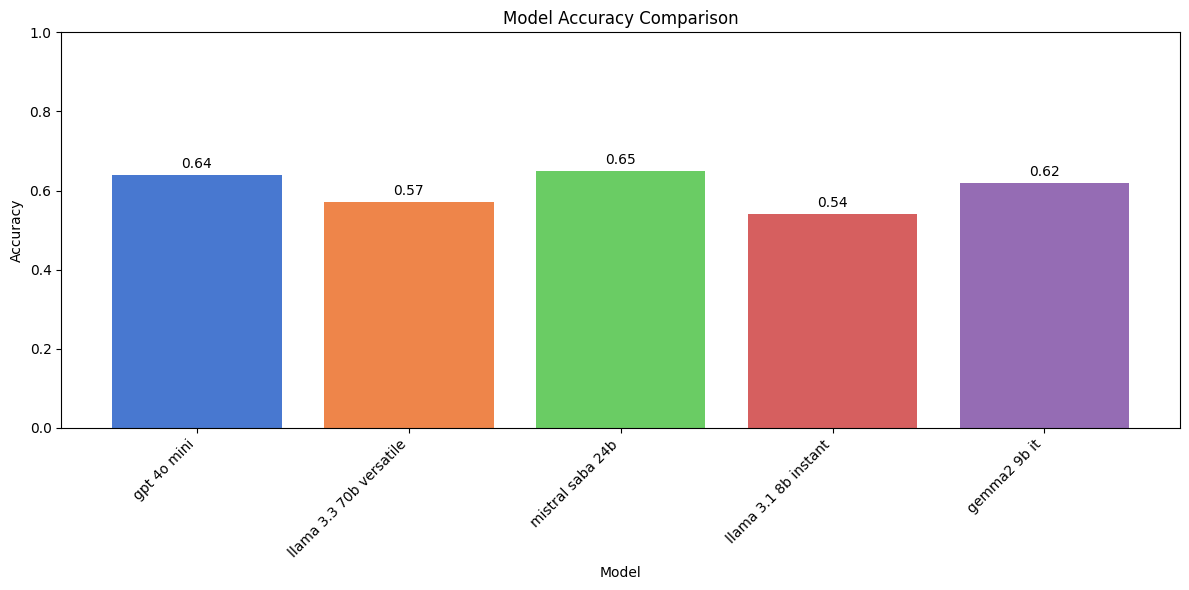

In [77]:
# Generate accuracy comparison chart
plot_accuracy_comparison(model_metrics, plots_dir)

## Class-specific Performance Analysis

Let's examine how well the models handle each answer class (yes/no/maybe).

In [78]:
# Show detailed metrics for each model
for model_id, metrics in model_metrics.items():
    print(f"\n=== {model_id} ===\n")
    
    # Create a DataFrame for better visualization of the report
    report = metrics['report']
    report_df = pd.DataFrame({
        'Precision': [report[label]['precision'] for label in ['yes', 'no', 'maybe']],
        'Recall': [report[label]['recall'] for label in ['yes', 'no', 'maybe']],
        'F1-score': [report[label]['f1-score'] for label in ['yes', 'no', 'maybe']],
        'Support': [report[label]['support'] for label in ['yes', 'no', 'maybe']]
    }, index=['yes', 'no', 'maybe'])
    
    display(report_df)


=== azure_gpt_4o_mini ===



,Precision,Recall,F1-score,Support
yes,0.634146,0.866667,0.732394,30.0
no,0.678571,0.633333,0.655172,30.0
maybe,0.612903,0.475000,0.535211,40.0



=== groq_llama_3.3_70b_versatile ===



,Precision,Recall,F1-score,Support
yes,0.529412,0.900000,0.666667,30.0
no,0.595238,0.833333,0.694444,30.0
maybe,0.714286,0.125000,0.212766,40.0



=== groq_mistral_saba_24b ===



,Precision,Recall,F1-score,Support
yes,0.80,0.533333,0.64,30.0
no,0.80,0.533333,0.64,30.0
maybe,0.55,0.825000,0.66,40.0



=== groq_llama_3.1_8b_instant ===



,Precision,Recall,F1-score,Support
yes,0.490566,0.866667,0.626506,30.0
no,0.595238,0.833333,0.694444,30.0
maybe,0.600000,0.075000,0.133333,40.0



=== groq_gemma2_9b_it ===



,Precision,Recall,F1-score,Support
yes,0.656250,0.700000,0.677419,30.0
no,0.846154,0.366667,0.511628,30.0
maybe,0.545455,0.750000,0.631579,40.0


<Figure size 1200x800 with 0 Axes>

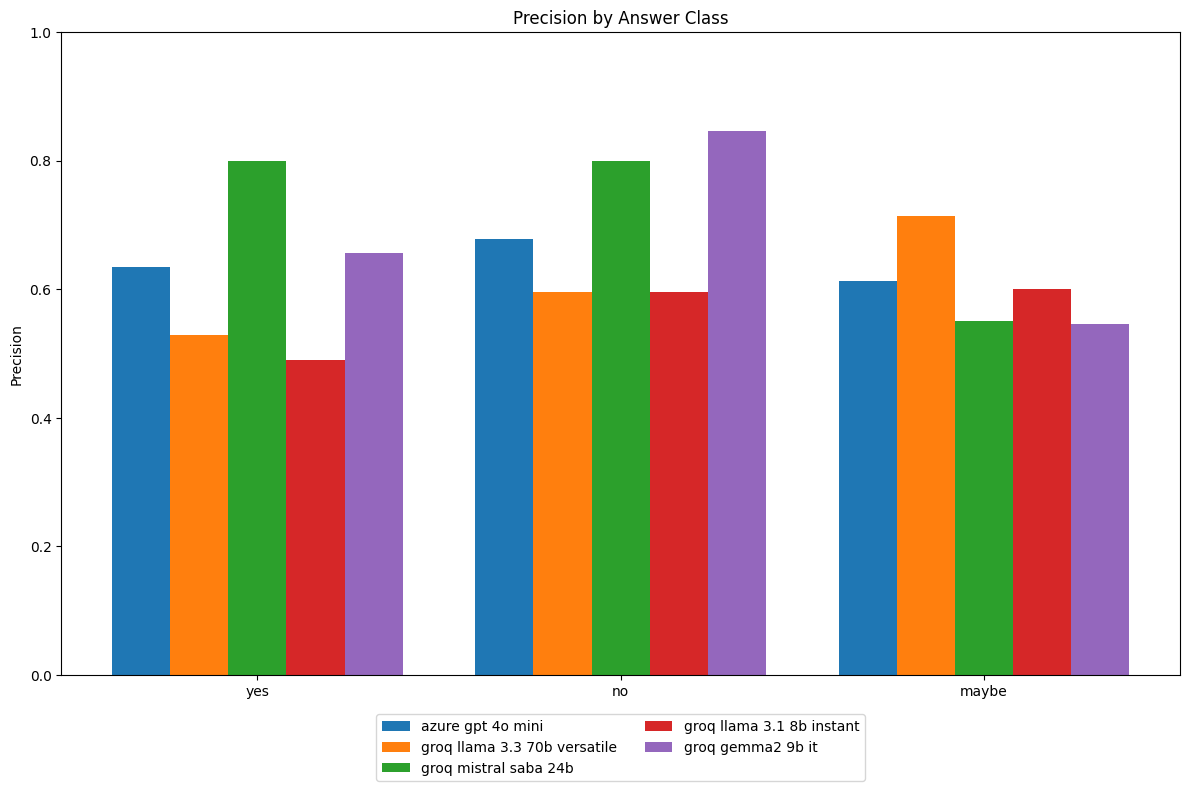

<Figure size 1200x800 with 0 Axes>

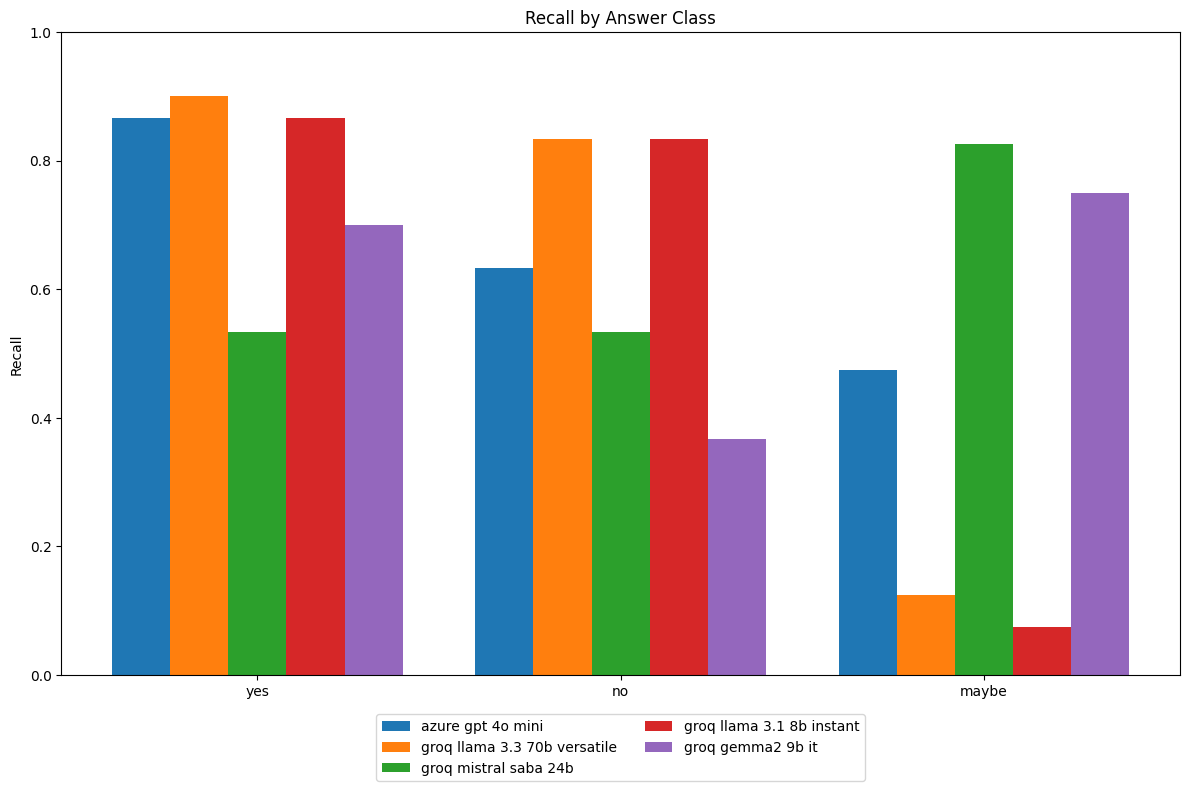

<Figure size 1200x800 with 0 Axes>

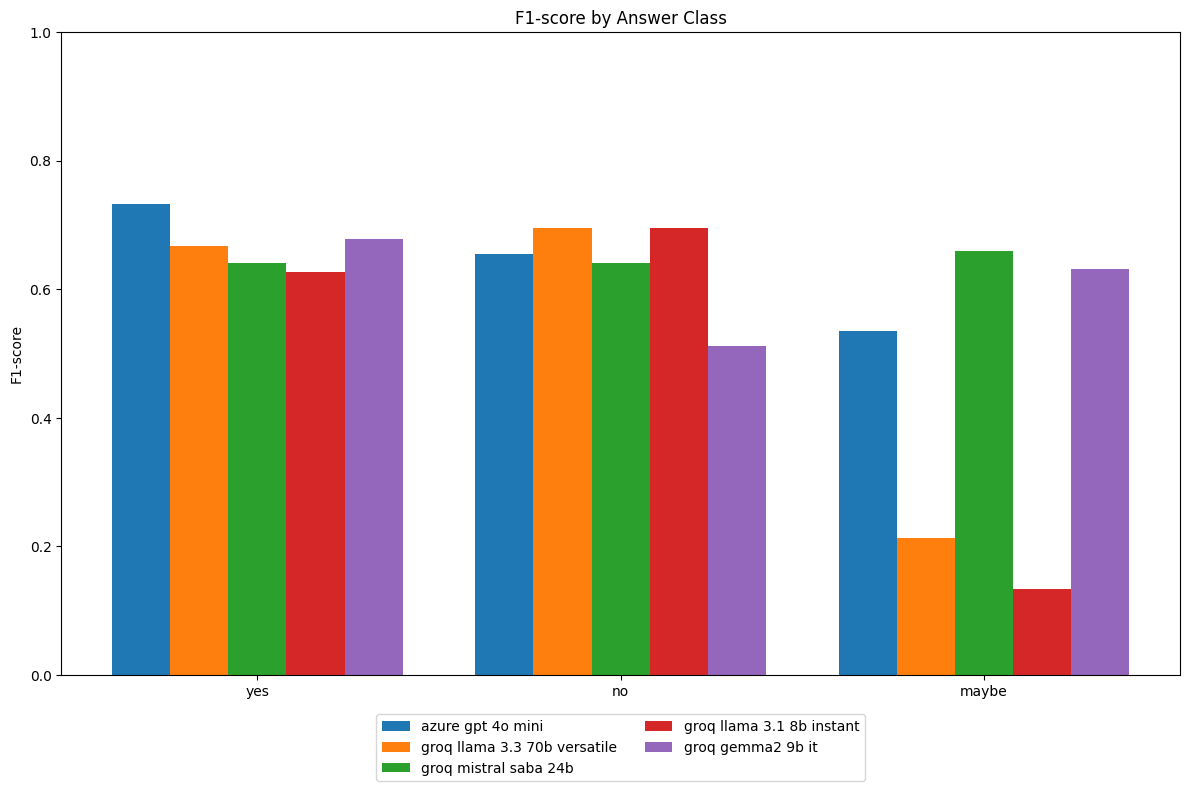

In [79]:
# Compare performance across classes for all models
model_names = list(model_metrics.keys())
class_labels = ['yes', 'no', 'maybe']
metrics_to_plot = ['precision', 'recall', 'f1-score']

# Plot precision, recall, and F1-score by class for each model
for metric in metrics_to_plot:
    plt.figure(figsize=(12, 8))
    
    # Create data for plotting
    data = {model: [] for model in model_names}
    for model in model_names:
        for label in class_labels:
            data[model].append(model_metrics[model]['report'][label][metric])
    
    # Plot grouped bar chart
    x = np.arange(len(class_labels))  # label locations
    width = 0.8 / len(model_names)    # width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for model, values in data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, values, width, label=model.replace('_', ' '))
        multiplier += 1
    
    # Add labels and legend
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} by Answer Class')
    ax.set_xticks(x + width * (len(model_names) - 1) / 2)
    ax.set_xticklabels(class_labels)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
    plt.ylim(0, 1.0)
    
    # Save the plot
    output_path = os.path.join(plots_dir, f'{metric}_by_class_balanced.png')
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()

## Error Analysis

Let's analyze the errors made by the models to understand what types of questions are challenging.

In [80]:
# Analyze errors for each model
def analyze_model_errors(model_id, results):
    errors = [r for r in results if not r['is_correct']]
    print(f"\n=== Error Analysis for {model_id} ===\n")
    print(f"Total errors: {len(errors)} out of {len(results)} samples ({len(errors)/len(results):.2%})")
    
    # Error distribution by correct answer
    error_by_answer = {}
    for answer in ['yes', 'no', 'maybe']:
        answer_errors = [e for e in errors if e['correct_answer'] == answer]
        error_by_answer[answer] = len(answer_errors)
        
    print("\nError distribution by correct answer:")
    for answer, count in error_by_answer.items():
        # Calculate the error rate for each class
        total_in_class = len([r for r in results if r['correct_answer'] == answer])
        error_rate = count / total_in_class if total_in_class > 0 else 0
        print(f"- {answer}: {count} errors out of {total_in_class} ({error_rate:.2%})")
    
    # Common error patterns (confusion matrix form)
    print("\nError patterns (what model predicted instead of correct answer):")
    pattern_counts = {}
    for error in errors:
        key = f"True: {error['correct_answer']}, Predicted: {error['processed_response']}"
        pattern_counts[key] = pattern_counts.get(key, 0) + 1
    
    for pattern, count in sorted(pattern_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"- {pattern}: {count}")
    
    # Show a few examples of errors
    print("\nExample errors:")
    for i, error in enumerate(errors[:3], 1):
        print(f"\nError {i}:")
        print(f"Question: {error['question']}")
        print(f"Correct Answer: {error['correct_answer']}")
        print(f"Model Answer: {error['processed_response']}")
        print(f"Raw Response: {error['model_response']}")

# Analyze the first model errors
if all_model_results:
    first_model_id = list(all_model_results.keys())[0]
    analyze_model_errors(first_model_id, all_model_results[first_model_id])


=== Error Analysis for azure_gpt_4o_mini ===

Total errors: 36 out of 100 samples (36.00%)

Error distribution by correct answer:
- yes: 4 errors out of 30 (13.33%)
- no: 11 errors out of 30 (36.67%)
- maybe: 21 errors out of 40 (52.50%)

Error patterns (what model predicted instead of correct answer):
- True: maybe, Predicted: yes: 13
- True: no, Predicted: maybe: 9
- True: maybe, Predicted: no: 8
- True: yes, Predicted: maybe: 3
- True: no, Predicted: yes: 2
- True: yes, Predicted: no: 1

Example errors:

Error 1:
Question: Are bipolar disorders underdiagnosed in patients with depressive episodes?
Correct Answer: maybe
Model Answer: yes
Raw Response: yes

Error 2:
Question: Can calprotectin predict relapse risk in inflammatory bowel disease?
Correct Answer: maybe
Model Answer: yes
Raw Response: yes

Error 3:
Question: Characterization of the gender dimorphism after injury and hemorrhagic shock: are hormonal differences responsible?
Correct Answer: no
Model Answer: maybe
Raw Response

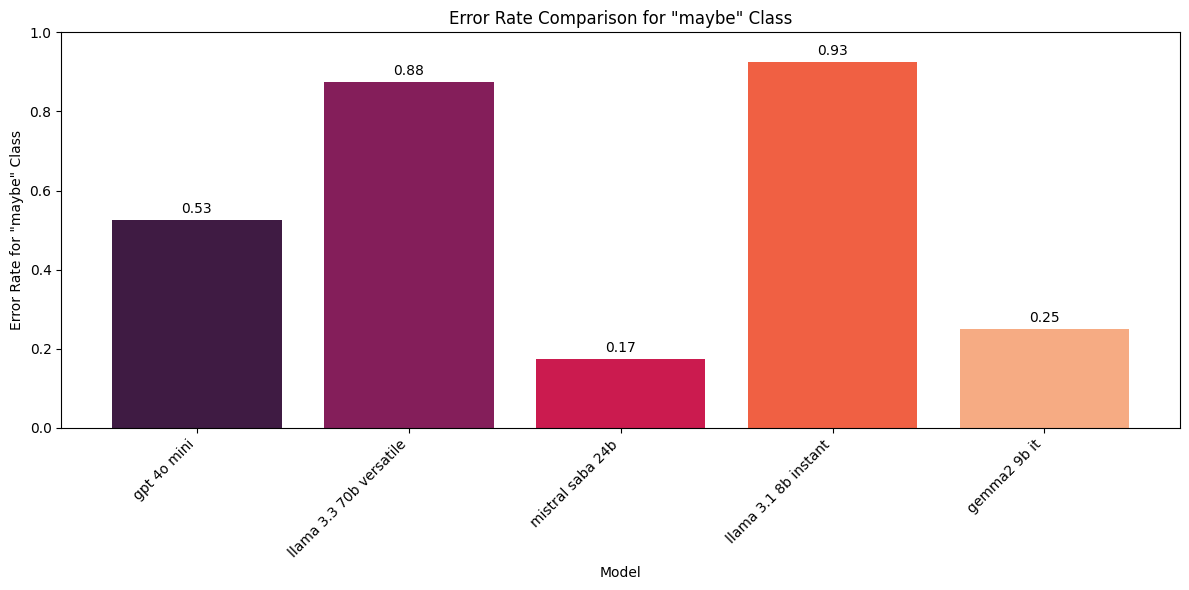

In [81]:
# Compare error rates for 'maybe' class across models
maybe_error_rates = {}

for model_id, results in all_model_results.items():
    maybe_samples = [r for r in results if r['correct_answer'] == 'maybe']
    maybe_errors = [r for r in maybe_samples if not r['is_correct']]
    error_rate = len(maybe_errors) / len(maybe_samples) if maybe_samples else 0
    maybe_error_rates[model_id] = error_rate

# Plot the maybe error rates
plt.figure(figsize=(12, 6))
models = list(maybe_error_rates.keys())
rates = list(maybe_error_rates.values())
display_names = [model.replace('_', ' ').replace('azure ', '').replace('groq ', '') for model in models]

bars = plt.bar(display_names, rates, color=sns.color_palette('rocket', len(models)))

plt.xlabel('Model')
plt.ylabel('Error Rate for "maybe" Class')
plt.title('Error Rate Comparison for "maybe" Class')
plt.ylim(0.0, 1.0)
plt.xticks(rotation=45, ha='right')

# Add error rate values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.2f}', ha='center', va='bottom', rotation=0)

plt.tight_layout()
output_path = os.path.join(plots_dir, 'maybe_error_rate_comparison.png')
plt.savefig(output_path)
plt.show()

In [82]:
# Show detailed metrics for each model
for model_id, metrics in model_metrics.items():
    print(f"\n=== {model_id} ===\n")
    
    # Get the classification report
    report = metrics['report']
    
    # Create a DataFrame for better visualization
    report_df = pd.DataFrame({
        'Precision': [report[label]['precision'] for label in ['yes', 'no', 'maybe']],
        'Recall': [report[label]['recall'] for label in ['yes', 'no', 'maybe']],
        'F1-score': [report[label]['f1-score'] for label in ['yes', 'no', 'maybe']],
        'Support': [report[label]['support'] for label in ['yes', 'no', 'maybe']]
    }, index=['yes', 'no', 'maybe'])
    
    display(report_df)


=== azure_gpt_4o_mini ===



,Precision,Recall,F1-score,Support
yes,0.634146,0.866667,0.732394,30.0
no,0.678571,0.633333,0.655172,30.0
maybe,0.612903,0.475000,0.535211,40.0



=== groq_llama_3.3_70b_versatile ===



,Precision,Recall,F1-score,Support
yes,0.529412,0.900000,0.666667,30.0
no,0.595238,0.833333,0.694444,30.0
maybe,0.714286,0.125000,0.212766,40.0



=== groq_mistral_saba_24b ===



,Precision,Recall,F1-score,Support
yes,0.80,0.533333,0.64,30.0
no,0.80,0.533333,0.64,30.0
maybe,0.55,0.825000,0.66,40.0



=== groq_llama_3.1_8b_instant ===



,Precision,Recall,F1-score,Support
yes,0.490566,0.866667,0.626506,30.0
no,0.595238,0.833333,0.694444,30.0
maybe,0.600000,0.075000,0.133333,40.0



=== groq_gemma2_9b_it ===



,Precision,Recall,F1-score,Support
yes,0.656250,0.700000,0.677419,30.0
no,0.846154,0.366667,0.511628,30.0
maybe,0.545455,0.750000,0.631579,40.0
